In [4]:
#!pip install tensorflow

In [5]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

data = pd.read_csv('data_no_bg.csv')

# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(data.espece.unique())

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab


### Division du jeu de données en 10 dataframes équilibrés

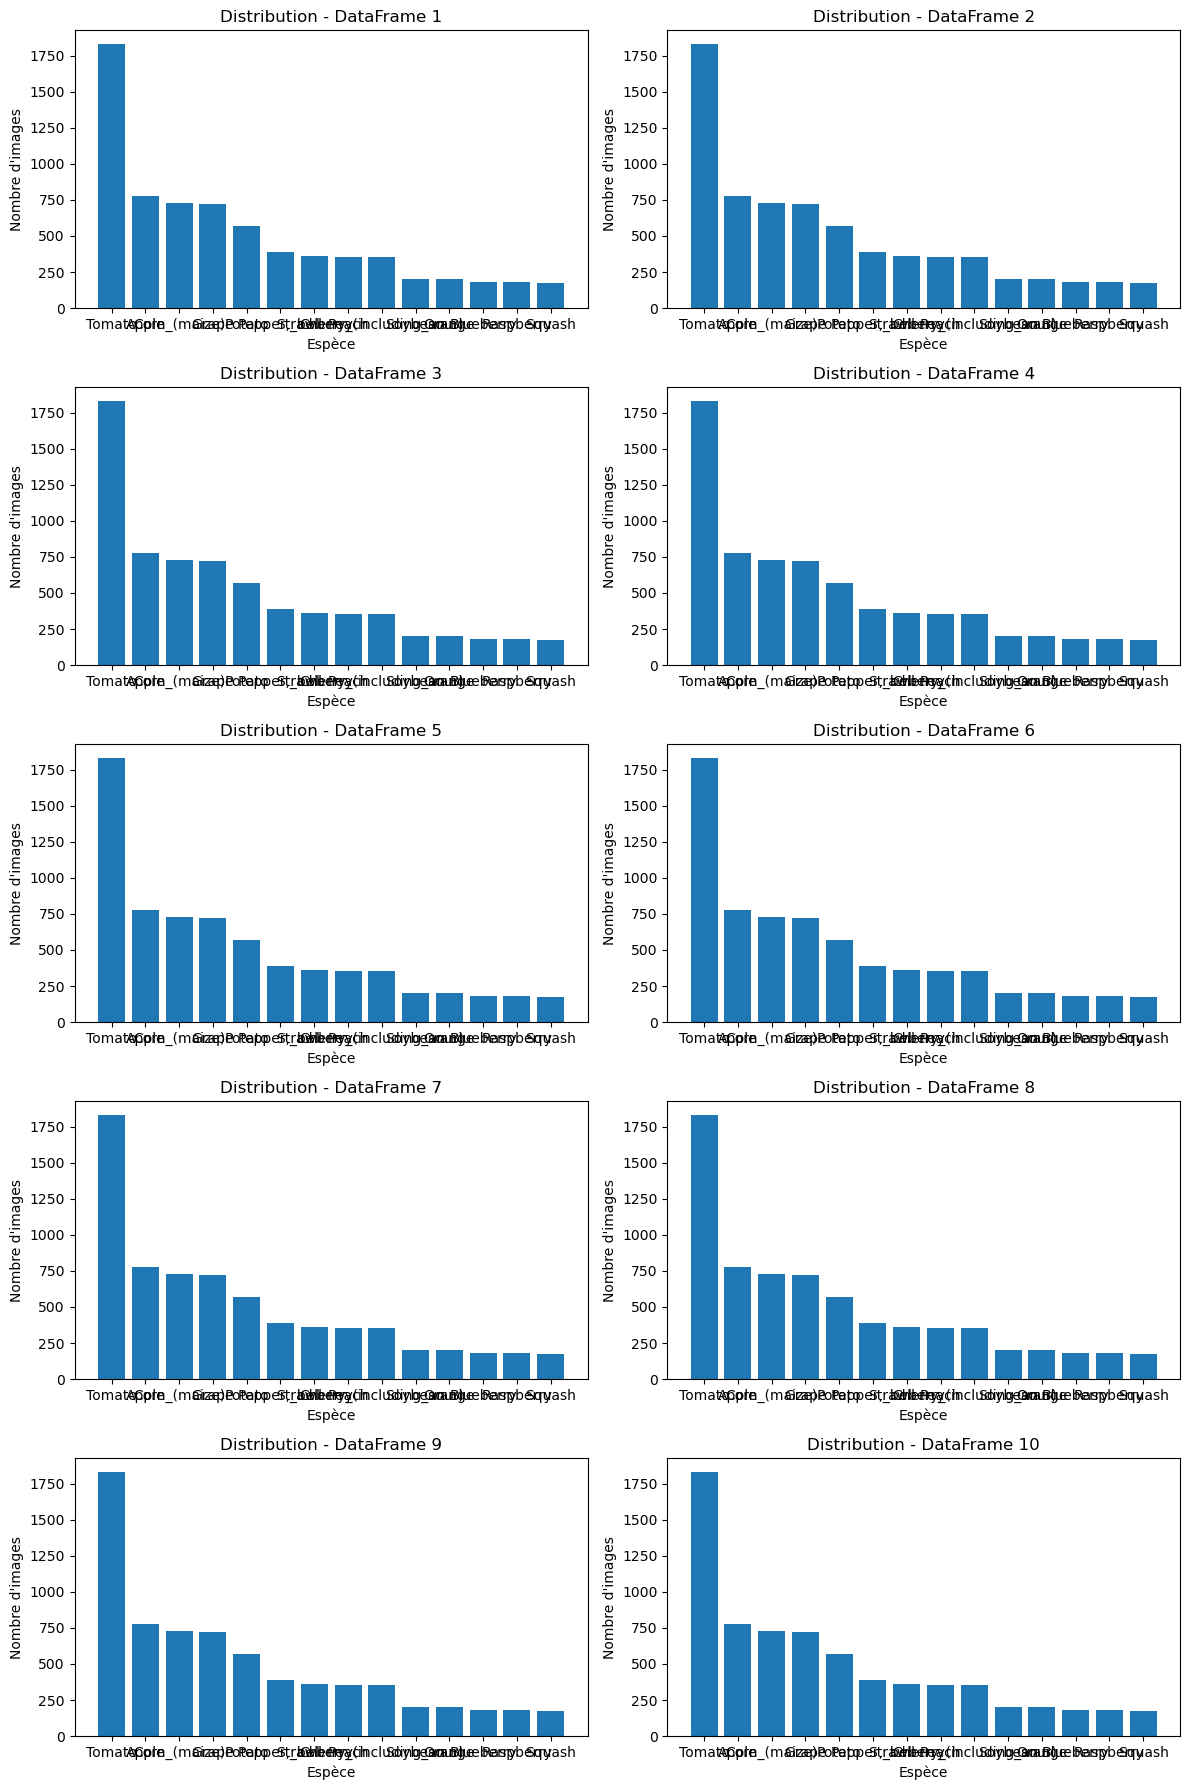

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['espece']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['espece'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Espèce")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [7]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 56

### Modèle

In [8]:
# VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freezing

for layer in base_model.layers:
    layer.trainable = False

# Nouvelles couches 

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compilation

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 27s 0us/step


In [9]:
checkpoint_callback = ModelCheckpoint(
    'tf_VGG16_id_espece.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(5):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.0483 - accuracy: 0.3433
Epoch 1: val_accuracy improved from -inf to 0.47917, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 854s 10s/step - loss: 2.0483 - accuracy: 0.3433 - val_loss: 1.7206 - val_accuracy: 0.4792
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.5464
Epoch 2: val_accuracy improved from 0.47917 to 0.61161, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 885s 10s/step - loss: 1.4891 - accuracy: 0.5464 - val_loss: 1.2893 - val_accuracy: 0.6116
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.1574 - accuracy: 0.6471
Epoch 3: val_accuracy improved from 0.61161 to 0.70164, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 883s 10s/step - loss: 1.1574 - accuracy: 0.6471 - val_loss: 1.0310 - val_accuracy: 0.7016
Epoch 4/8
87

87/87 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.9205
Epoch 3: val_accuracy improved from 0.91815 to 0.91890, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 881s 10s/step - loss: 0.2732 - accuracy: 0.9205 - val_loss: 0.2872 - val_accuracy: 0.9189
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9216
Epoch 4: val_accuracy improved from 0.91890 to 0.92039, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 883s 10s/step - loss: 0.2688 - accuracy: 0.9216 - val_loss: 0.2805 - val_accuracy: 0.9204
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9221
Epoch 5: val_accuracy did not improve from 0.92039
87/87 [==============================] - 889s 10s/step - loss: 0.2596 - accuracy: 0.9221 - val_loss: 0.2743 - val_accuracy: 0.9137
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9255
Epoch 

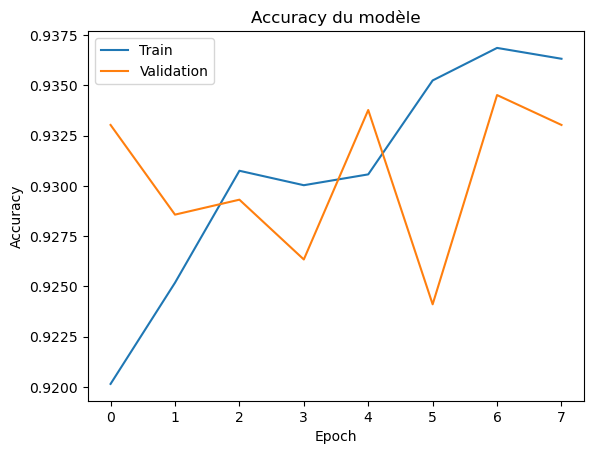

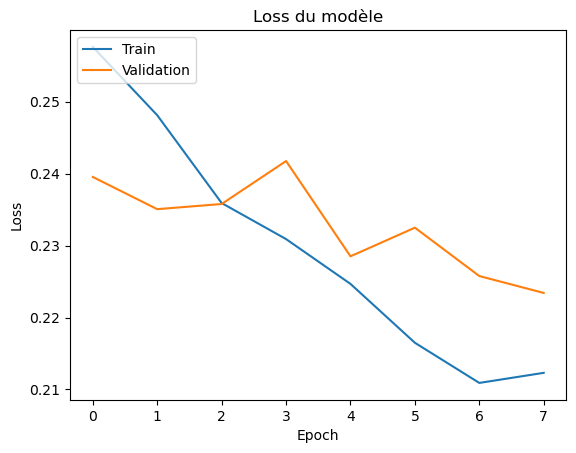

In [10]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Enregistrement du modèle

In [11]:
# Chargement du modèle

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.load_weights('tf_VGG16_id_espece.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_tf_VGG16_id_espece.h5')